In [15]:
from psychopy import visual, event, core
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter

In [55]:
# Gabor Stimulus 
def ShowImage(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off') 
    plt.show()

def GaborImage(ori, size=128, frequency=5, sigma=0.2):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)

    if ori == 'left':
        theta = np.deg2rad(-45)
    else:
        theta = np.deg2rad(45)
        
    X_rotated = X * np.cos(theta) + Y * np.sin(theta)

    grating = np.cos(2 * np.pi * frequency * X_rotated)

    envelope = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    gabor = grating * envelope
    gabor = (gabor - gabor.min()) / (gabor.max() - gabor.min())

    return gabor.astype(np.float32)

def GaborStimulus(ori, alpha = 0.1, show = False):
    gabor = GaborImage(ori = ori)
    
    noise = np.clip(np.random.normal(0.5, 0.01, gabor.shape), 0, 1)
    gabor =  alpha * gabor + (1- alpha) * noise

    if show == True:
        ShowImage(gabor)

    return gabor

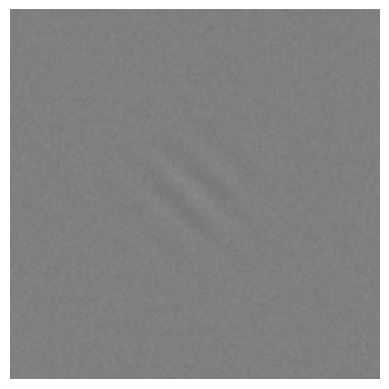

array([[0.50175745, 0.49775087, 0.49781891, ..., 0.50910015, 0.51313975,
        0.51612645],
       [0.50454813, 0.48095941, 0.48450585, ..., 0.4874691 , 0.49097968,
        0.50526418],
       [0.49729602, 0.49198923, 0.48733134, ..., 0.49694419, 0.49645582,
        0.49784006],
       ...,
       [0.49661502, 0.49420393, 0.5023646 , ..., 0.50103844, 0.49968476,
        0.49399209],
       [0.49500395, 0.49636922, 0.49938082, ..., 0.50822403, 0.4995668 ,
        0.48844144],
       [0.50040732, 0.51229807, 0.50622919, ..., 0.48872816, 0.49967115,
        0.47171801]])

In [59]:
GaborStimulus(ori = 'left', alpha = 0.05, show = True)

12.4079 	WARNING 	Monitor specification not found. Creating a temporary one...


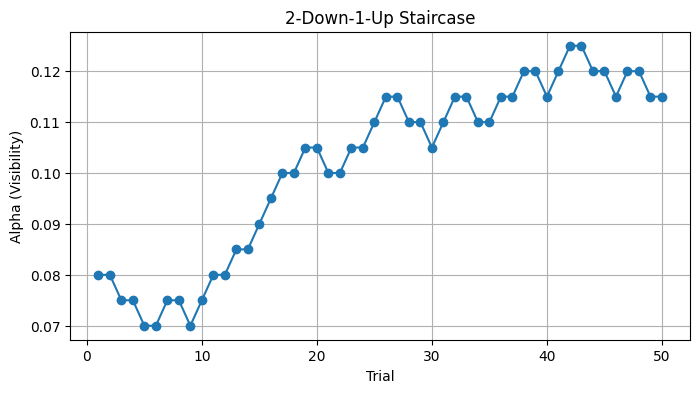

In [12]:
def Norm(image):
    return 2 * image - 1

# Visual Setup
win = visual.Window(size=(512, 512), color=0, units="pix", fullscr=False)
stim = visual.ImageStim(win, size=(512, 512), units="pix")

# Parameters
oris = ['left', 'right']
alpha = 0.08
step_size = 0.005
n_trials = 50
correct_counter = 0
data = []

# Instructions Screen
instruction = visual.TextStim(win, text="Press SPACE to begin the task.\nIdentify the orientation of the gabor using x (left) amd m (right).", color=1.0, height=24)
instruction.draw()
win.flip()

# Wait for spacebar to begin
event.waitKeys(keyList=['space'])
win.flip()


# Trial Loop
for trial in range(n_trials):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break
    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5) 
    ori = random.choice(oris)
    stim.image = np.flipud(Norm(GaborStimulus(ori, alpha=alpha)))
    stim.draw()
    win.flip()
    core.wait(0.5)  
    win.flip()
    
    keys = event.waitKeys(keyList=['x','m'] + ['escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break

    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori
    data.append({"trial": trial+1, "orientation": ori, "response": response,
                 "correct": correct, "alpha": alpha})
    if correct:
        correct_counter += 1
        if correct_counter == 2:
            alpha = max(0, alpha - step_size)
            correct_counter = 0
    else:
        alpha = min(1.0, alpha + step_size)
        correct_counter = 0

# Cleanup 
win.close()

# ---------- Plot ----------
alphas = [d["alpha"] for d in data]
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_trials + 1), alphas, marker='o')
plt.xlabel("Trial")
plt.ylabel("Alpha (Visibility)")
plt.title("2-Down-1-Up Staircase")
plt.grid(True)
plt.show()

# Optional: save data
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("Results.csv", index=False)